# Attention seq2seq in PyTorch

## Table of contents

1. [Understanding Attention in seq2seq Models](#understanding-attention-in-seq2seq-models)
2. [Setting up the environment](#setting-up-the-environment)
3. [Preparing the dataset](#preparing-the-dataset)
4. [Building the Encoder model](#building-the-encoder-model)
5. [Building the Attention mechanism](#building-the-attention-mechanism)
6. [Building the Decoder model with Attention](#building-the-decoder-model-with-attention)
7. [Combining Encoder and Decoder into an Attention seq2seq model](#combining-encoder-and-decoder-into-an-attention-seq2seq-model)
8. [Training the Attention seq2seq model](#training-the-attention-seq2seq-model)
9. [Evaluating the Attention seq2seq model](#evaluating-the-attention-seq2seq-model)
10. [Visualizing Attention weights](#visualizing-attention-weights)
11. [Experimenting with hyperparameters](#experimenting-with-hyperparameters)

## Understanding Attention in seq2seq Models

### **Key concepts**
Attention-based Sequence-to-Sequence (seq2seq) models enhance traditional seq2seq architectures by allowing the decoder to selectively focus on specific parts of the input sequence during generation. Instead of relying solely on a single context vector, attention mechanisms compute dynamic weights over the encoder’s hidden states, enabling the model to capture more nuanced relationships between input and output tokens.

Key components of attention seq2seq models include:
- **Encoder**: Processes the input sequence and outputs a series of hidden states rather than a single context vector.
- **Attention Mechanism**: Calculates attention scores (or weights) that determine which parts of the input sequence are most relevant for generating each output token.
- **Decoder with Attention**: Generates the output sequence by combining the attention-weighted encoder states and its own hidden states at each step.
- **Alignment Scores**: Methods like dot-product or additive scoring measure relevance between encoder and decoder states.

Attention mechanisms address the limitations of standard seq2seq models, especially for long input sequences, by providing a flexible framework for dynamic context retrieval.

### **Applications**
Attention seq2seq models are widely used in tasks requiring context-aware sequence generation:
- **Machine translation**: Translating text with improved handling of long sentences and complex grammar.
- **Text summarization**: Generating concise and coherent summaries of large documents.
- **Speech-to-text**: Converting audio signals into text sequences with high accuracy.
- **Conversational AI**: Producing context-aware responses in chatbots and dialogue systems.
- **Code generation**: Translating human-readable descriptions into structured programming code.

### **Advantages**
- **Improved handling of long sequences**: Allows the decoder to focus on relevant parts of the input, mitigating the information bottleneck.
- **Dynamic context**: Tailors the context dynamically for each output token.
- **Explainability**: Attention weights provide insights into the model’s focus during generation.
- **Scalability**: Can be seamlessly integrated with other architectures like transformers for further enhancements.

### **Challenges**
- **Computational cost**: Calculating attention scores for every input-output pair increases complexity, especially for long sequences.
- **Overfitting**: Attention models can overfit small datasets if not properly regularized.
- **Alignment sensitivity**: Performance depends on the quality of alignment between input and output sequences.
- **Training complexity**: Requires additional computation and hyperparameter tuning compared to standard seq2seq models.

## Setting up the environment


##### **Q1: How do you install the necessary libraries for building and training an attention-based seq2seq model in PyTorch?**


In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install numpy matplotlib scikit-learn pandas

##### **Q2: How do you import the required modules for data loading, model building, and training in PyTorch?**


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import math
import os
import requests
import zipfile
from collections import Counter
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu

[nltk_data] Downloading package punkt to /home/fellmir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##### **Q3: How do you set up the environment to use a GPU for training the attention-based seq2seq model in PyTorch?**


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


##### **Q4: How do you set random seeds in PyTorch to ensure reproducibility when training the attention-based seq2seq model?**

In [4]:
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Preparing the dataset


##### **Q5: How do you load a machine translation dataset for an Attention seq2seq model?**


In [5]:
import os

dataset_url = 'https://www.manythings.org/anki/fra-eng.zip'
dataset_dir = 'data'
dataset_zip = os.path.join(dataset_dir, 'fra-eng.zip')
dataset_file = os.path.join(dataset_dir, 'fra.txt')

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

if not os.path.exists(dataset_zip):
    print("Downloading dataset using wget...")
    os.system(f"wget -O {dataset_zip} {dataset_url}")
else:
    print("Dataset already downloaded.")

if not os.path.exists(dataset_file):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
else:
    print("Dataset already extracted.")

Dataset already downloaded.
Dataset already extracted.


In [6]:
data = []
with open(dataset_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            eng_sentence, fr_sentence = parts[0], parts[1]
            data.append((eng_sentence, fr_sentence))

print(f"Loaded {len(data)} sentence pairs.")

Loaded 232736 sentence pairs.


##### **Q6: How do you tokenize the dataset and convert sentences into sequences of indices for machine translation tasks?**


In [7]:
def tokenize(sentence):
    return sentence.lower().strip().split()

In [8]:
tokenized_data = []
for eng, fr in data:
    tokenized_eng = tokenize(eng)
    tokenized_fr = tokenize(fr)
    tokenized_data.append((tokenized_eng, tokenized_fr))

##### **Q7: How do you create vocabulary mappings for both source and target languages?**


In [9]:
def build_vocab(tokenized_sentences, max_vocab_size=10000):
    word_counts = Counter()
    for sentence in tokenized_sentences:
        word_counts.update(sentence)
    most_common_words = word_counts.most_common(max_vocab_size - 4)  # Most common words up to max_vocab_size
    vocab = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
    for word, _ in most_common_words:
        vocab[word] = len(vocab)
    return vocab

In [10]:
source_sentences = [pair[0] for pair in tokenized_data]
target_sentences = [pair[1] for pair in tokenized_data]

source_vocab = build_vocab(source_sentences, max_vocab_size=1000)
target_vocab = build_vocab(target_sentences, max_vocab_size=1000)

inv_source_vocab = {i: w for w, i in source_vocab.items()}
inv_target_vocab = {i: w for w, i in target_vocab.items()}

print(f"Source vocabulary size: {len(source_vocab)}")
print(f"Target vocabulary size: {len(target_vocab)}")

Source vocabulary size: 1000
Target vocabulary size: 1000


##### **Q8: How do you set up DataLoaders to handle batching of source-target sentence pairs for training the model?**

In [11]:
class TranslationDataset(Dataset):
    def __init__(self, data, source_vocab, target_vocab):
        self.data = data
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.data)

    def encode_sentence(self, sentence, vocab):
        return [vocab.get(word, vocab['<UNK>']) for word in sentence]

    def __getitem__(self, idx):
        source_sentence, target_sentence = self.data[idx]
        source_indexes = [self.source_vocab['<SOS>']] + self.encode_sentence(source_sentence, self.source_vocab) + [self.source_vocab['<EOS>']]
        target_indexes = [self.target_vocab['<SOS>']] + self.encode_sentence(target_sentence, self.target_vocab) + [self.target_vocab['<EOS>']]
        return torch.tensor(source_indexes), torch.tensor(target_indexes)

In [12]:
train_data, val_data = train_test_split(tokenized_data, test_size=0.1, random_state=seed)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

train_dataset = TranslationDataset(train_data, source_vocab, target_vocab)
val_dataset = TranslationDataset(val_data, source_vocab, target_vocab)

Training data size: 209462
Validation data size: 23274


In [13]:
def collate_fn(batch):
    source_batch, target_batch = zip(*batch)
    source_lengths = torch.tensor([len(seq) for seq in source_batch], dtype=torch.long)
    target_lengths = torch.tensor([len(seq) for seq in target_batch], dtype=torch.long)
    source_padded = nn.utils.rnn.pad_sequence(source_batch, padding_value=source_vocab['<PAD>'], batch_first=True)
    target_padded = nn.utils.rnn.pad_sequence(target_batch, padding_value=target_vocab['<PAD>'], batch_first=True)
    return source_padded, target_padded, source_lengths, target_lengths

In [14]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Building the Encoder model


##### **Q9: How do you define the architecture of the Encoder model using PyTorch’s `nn.Module`?**


In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=source_vocab['<PAD>'])
        self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x, x_lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, x_lengths, batch_first=True, enforce_sorted=False)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        return outputs, hidden

##### **Q10: How do you implement the forward pass of the Encoder to generate a sequence of hidden states instead of a single context vector?**


In [16]:
# See the forward pass above, i.e.,
# def forward(self, x, x_lengths):
#     embedded = self.embedding(x)
#     packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, x_lengths, batch_first=True, enforce_sorted=False)
#     packed_outputs, hidden = self.rnn(packed_embedded)
#     outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
#     return outputs, hidden

##### **Q11: How do you specify the number of hidden units and layers in the Encoder, and how does this affect performance?**

In [17]:
input_dim = len(source_vocab)
embed_dim = 128
hidden_dim = 256
num_layers = 1

encoder = Encoder(input_dim, embed_dim, hidden_dim, num_layers).to(device)

## Building the Attention mechanism


##### **Q12: How do you implement the attention mechanism to calculate attention scores between encoder hidden states and the decoder's current hidden state?**


In [18]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 3, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask):
        seq_len = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        attention = attention.masked_fill(mask == 0, -1e10)
        return torch.softmax(attention, dim=1)

##### **Q13: How do you define the attention scoring function to compute the relevance of each input token during decoding?**


In [19]:
# See forward pass above, i.e.,
# energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
# attention = self.v(energy).squeeze(2)

##### **Q14: How do you apply the attention weights to compute a context vector for each decoding step?**

In [20]:
def apply_attention(attention_weights, encoder_outputs):
    attention_weights = attention_weights.unsqueeze(1)
    context = torch.bmm(attention_weights, encoder_outputs)
    context = context.squeeze(1)
    return context

## Building the Decoder model with Attention


##### **Q15: How do you modify the Decoder model to include the attention mechanism in its architecture?**


In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers, attention):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, embed_dim, padding_idx=target_vocab['<PAD>'])
        self.rnn = nn.GRU(embed_dim + hidden_dim * 2, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 3, output_dim)
        self.attention = attention

    def forward(self, input_token, hidden, encoder_outputs, mask):
        input_token = input_token.unsqueeze(1)
        embedded = self.embedding(input_token)
        attention_weights = self.attention(hidden[-1], encoder_outputs, mask)
        context = apply_attention(attention_weights, encoder_outputs)
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        output = output.squeeze(1)
        output = torch.cat((output, context), dim=1)
        prediction = self.fc(output)
        return prediction, hidden, attention_weights

##### **Q16: How do you implement the forward pass of the Decoder with attention, using the context vector and hidden state to generate each output token?**


In [22]:
# See forward pass above, i.e.,
# def forward(self, input_token, hidden, encoder_outputs, mask):
#     input_token = input_token.unsqueeze(1)
#     embedded = self.embedding(input_token)
#     attention_weights = self.attention(hidden[-1], encoder_outputs, mask)
#     context = apply_attention(attention_weights, encoder_outputs)
#     rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)
#     output, hidden = self.rnn(rnn_input, hidden)
#     output = output.squeeze(1)
#     output = torch.cat((output, context), dim=1)
#     prediction = self.fc(output)
#     return prediction, hidden, attention_weights

##### **Q17: How do you use `nn.Linear` and `nn.Softmax` layers in the Decoder to convert the attention-weighted hidden state into predicted tokens?**

In [23]:
# self.fc = nn.Linear(hidden_dim * 3, output_dim)
# prediction = self.fc(output)

## Combining Encoder and Decoder into an Attention seq2seq model


##### **Q18: How do you combine the Encoder and Decoder models into a complete seq2seq model with attention?**


In [24]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src):  # Generates a mask to ignore padding tokens in attention computations
        mask = (src != source_vocab['<PAD>']).to(self.device)
        return mask

    def forward(self, source, source_lengths, target, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = target.size(1)
        target_vocab_size = self.decoder.embedding.num_embeddings

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(source, source_lengths)

        hidden = hidden[:self.decoder.rnn.num_layers]
        input_token = target[:, 0]
        mask = self.create_mask(source)

        for t in range(1, target_len):
            output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs, mask)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = target[:, t] if teacher_force else top1

        return outputs

##### **Q19: How do you implement teacher forcing in the training loop to improve the performance of the attention-based seq2seq model?**


In [25]:
# In the forward pass above:
# teacher_force = random.random() < teacher_forcing_ratio
# input_token = target[:, t] if teacher_force else top1

##### **Q20: How do you implement the forward pass of the complete attention-based seq2seq model, using the context vector and attention weights at each decoding step?**

In [26]:
# See forward pass above, i.e.,
# def forward(self, source, source_lengths, target, teacher_forcing_ratio=0.5):
#     batch_size = source.size(0)
#     target_len = target.size(1)
#     target_vocab_size = self.decoder.embedding.num_embeddings

#     outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
#     encoder_outputs, hidden = self.encoder(source, source_lengths)

#     hidden = hidden[:self.decoder.rnn.num_layers]
#     input_token = target[:, 0]
#     mask = self.create_mask(source)

#     for t in range(1, target_len):
#         output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs, mask)
#         outputs[:, t] = output
#         teacher_force = random.random() < teacher_forcing_ratio
#         top1 = output.argmax(1)
#         input_token = target[:, t] if teacher_force else top1

#     return outputs

## Training the Attention seq2seq model


##### **Q21: How do you define the loss function to measure the difference between the predicted and actual target sequences?**


In [27]:
criterion = nn.CrossEntropyLoss(ignore_index=target_vocab['<PAD>'])

##### **Q22: How do you configure the optimizer to update the parameters of both the Encoder and Decoder models during training?**


In [28]:
input_dim = len(source_vocab)
output_dim = len(target_vocab)
embed_dim = 128
hidden_dim = 256
num_layers = 1

encoder = Encoder(input_dim, embed_dim, hidden_dim, num_layers).to(device)
attention = Attention(hidden_dim).to(device)
decoder = Decoder(output_dim, embed_dim, hidden_dim, num_layers, attention).to(device)
seq2seq_model = Seq2Seq(encoder, decoder, device).to(device)

In [29]:
optimizer = optim.Adam(seq2seq_model.parameters(), lr=0.001)

##### **Q23: How do you implement the training loop, including forward pass, loss calculation, backpropagation, and logging of the training loss?**


In [30]:
def train(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio):
    model.train()
    epoch_loss = 0
    for source_batch, target_batch, source_lengths, _ in iterator:
        source_batch = source_batch.to(device)
        target_batch = target_batch.to(device)
        if isinstance(source_lengths, torch.Tensor):
            source_lengths = source_lengths.tolist()
        source_lengths = torch.tensor(source_lengths, dtype=torch.long)

        optimizer.zero_grad()
        output = model(source_batch, source_lengths, target_batch, teacher_forcing_ratio)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        target = target_batch[:, 1:].reshape(-1)

        loss = criterion(output, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

##### **Q24: How do you monitor and log the loss during training to ensure the model is converging and learning effectively?**

In [31]:
num_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
train_losses = []

for epoch in range(num_epochs):
    train_loss = train(seq2seq_model, train_loader, optimizer, criterion, clip, teacher_forcing_ratio)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

Epoch [1/10], Train Loss: 1.8530
Epoch [2/10], Train Loss: 1.5335
Epoch [3/10], Train Loss: 1.4552
Epoch [4/10], Train Loss: 1.4119
Epoch [5/10], Train Loss: 1.3856
Epoch [6/10], Train Loss: 1.3676
Epoch [7/10], Train Loss: 1.3576
Epoch [8/10], Train Loss: 1.3504
Epoch [9/10], Train Loss: 1.3437
Epoch [10/10], Train Loss: 1.3448


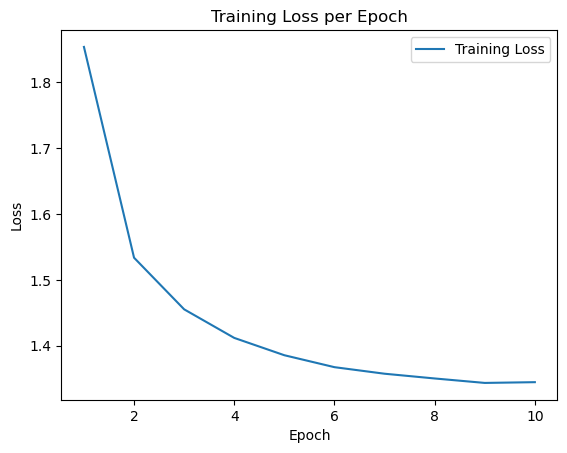

In [32]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

## Evaluating the Attention seq2seq model


##### **Q25: How do you evaluate the attention-based seq2seq model on a validation set using metrics such as BLEU score?**


In [33]:
def evaluate_bleu(model, iterator):
    model.eval()
    references = []
    hypotheses = []
    with torch.no_grad():
        for source_batch, target_batch, source_lengths, _ in iterator:
            source_batch = source_batch.to(device)
            target_batch = target_batch.to(device)
            if isinstance(source_lengths, torch.Tensor):
                source_lengths = source_lengths.tolist()
            source_lengths = torch.tensor(source_lengths, dtype=torch.long)

            encoder_outputs, hidden = model.encoder(source_batch, source_lengths)
            hidden = hidden[:model.decoder.rnn.num_layers]
            input_token = torch.tensor([target_vocab['<SOS>']] * source_batch.size(0)).to(device)
            mask = model.create_mask(source_batch)
            batch_hypotheses = [[] for _ in range(source_batch.size(0))]
            max_len = target_batch.size(1)
            for _ in range(max_len):
                output, hidden, _ = model.decoder(input_token, hidden, encoder_outputs, mask)
                top1 = output.argmax(1)
                input_token = top1
                for i in range(source_batch.size(0)):
                    token = top1[i].item()
                    if token != target_vocab['<EOS>'] and token != target_vocab['<PAD>']:
                        batch_hypotheses[i].append(inv_target_vocab.get(token, '<UNK>'))
            for i in range(source_batch.size(0)):
                target_sentence = target_batch[i].cpu().numpy()
                target_tokens = [inv_target_vocab.get(token, '<UNK>') for token in target_sentence if token not in (target_vocab['<SOS>'], target_vocab['<EOS>'], target_vocab['<PAD>'])]
                references.append([target_tokens])
                hypotheses.append(batch_hypotheses[i])
    bleu_score = corpus_bleu(references, hypotheses)
    return bleu_score

##### **Q26: How do you calculate the BLEU score to assess the quality of the translations produced by the model?**


In [34]:
valid_bleu = evaluate_bleu(seq2seq_model, val_loader)
print(f'Validation BLEU Score: {valid_bleu:.4f}')

Validation BLEU Score: 0.3489


##### **Q27: How do you compare the performance of the attention-based seq2seq model with a vanilla seq2seq model without attention?**

In [35]:
class DecoderWithoutAttention(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers):
        super(DecoderWithoutAttention, self).__init__()
        self.embedding = nn.Embedding(output_dim, embed_dim, padding_idx=target_vocab['<PAD>'])
        self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_token, hidden):
        input_token = input_token.unsqueeze(1)
        embedded = self.embedding(input_token)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden

In [36]:
encoder_wo_attention = Encoder(input_dim, embed_dim, hidden_dim, num_layers).to(device)
decoder_wo_attention = DecoderWithoutAttention(output_dim, embed_dim, hidden_dim, num_layers).to(device)

In [37]:
class Seq2SeqWithoutAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqWithoutAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, source_lengths, target, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = target.size(1)
        target_vocab_size = self.decoder.embedding.num_embeddings

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(source, source_lengths)

        hidden = hidden[:self.decoder.rnn.num_layers]  # Since the encoder is bidirectional, we need to combine the hidden states
        input_token = target[:, 0]

        for t in range(1, target_len):
            output, hidden = self.decoder(input_token, hidden)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = target[:, t] if teacher_force else top1

        return outputs

In [38]:
seq2seq_model_wo_attention = Seq2SeqWithoutAttention(encoder_wo_attention, decoder_wo_attention, device).to(device)

num_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
train_losses = []

for epoch in range(num_epochs):
    train_loss = train(seq2seq_model_wo_attention, train_loader, optimizer, criterion, clip, teacher_forcing_ratio)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

Epoch [1/10], Train Loss: 6.9182
Epoch [2/10], Train Loss: 6.9181
Epoch [3/10], Train Loss: 6.9180
Epoch [4/10], Train Loss: 6.9182
Epoch [5/10], Train Loss: 6.9182
Epoch [6/10], Train Loss: 6.9181
Epoch [7/10], Train Loss: 6.9181
Epoch [8/10], Train Loss: 6.9182
Epoch [9/10], Train Loss: 6.9182
Epoch [10/10], Train Loss: 6.9182


## Visualizing Attention weights


##### **Q28: How do you visualize the attention weights for specific input-output pairs using a heatmap?**


In [39]:
import seaborn as sns
import matplotlib.ticker as ticker

def visualize_attention(source_tokens, translated_tokens, attentions):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    sns.set()
    fig, ax = plt.subplots(figsize=(10, 8))
    attention = attentions[:len(translated_tokens), :len(source_tokens)+2]
    sns.heatmap(attention, 
                xticklabels=['<SOS>'] + source_tokens + ['<EOS>'], 
                yticklabels=translated_tokens, 
                ax=ax)
    ax.set_xlabel('Source Sentence')
    ax.set_ylabel('Translated Sentence')
    plt.xticks(rotation=45)
    plt.show()

In [40]:
def translate_sentence(model, sentence, source_vocab, target_vocab, inv_target_vocab, max_len=50):
    model.eval()
    tokens = tokenize(sentence)
    indexes = [source_vocab['<SOS>']] + [source_vocab.get(word, source_vocab['<UNK>']) for word in tokens] + [source_vocab['<EOS>']]
    src_tensor = torch.tensor(indexes).unsqueeze(0).to(device)
    src_length = torch.tensor([len(indexes)], dtype=torch.long)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_length)
        hidden = hidden[:model.decoder.rnn.num_layers]
        input_token = torch.tensor([target_vocab['<SOS>']]).to(device)
        mask = model.create_mask(src_tensor)
        attentions = torch.zeros(max_len, len(indexes)).to(device)
        translated_tokens = []
        for t in range(max_len):
            output, hidden, attention_weights = model.decoder(input_token, hidden, encoder_outputs, mask)
            attentions[t] = attention_weights
            top1 = output.argmax(1)
            token = top1.item()
            if token == target_vocab['<EOS>']:
                break
            translated_tokens.append(inv_target_vocab.get(token, '<UNK>'))
            input_token = top1
        attentions = attentions[:t+1]
    return translated_tokens, attentions.cpu().detach().numpy()

In [41]:
example_idx = 0  # Change the index to select different examples
source_tokens = val_data[example_idx][0]
target_tokens = val_data[example_idx][1]

source_sentence = ' '.join(source_tokens)
target_sentence = ' '.join(target_tokens)

print(f"Source Sentence: {source_sentence}")
print(f"Target Sentence: {target_sentence}")

Source Sentence: are you envious?
Target Sentence: êtes-vous jalouse ?


Translated Sentence: êtes-vous <UNK> ?


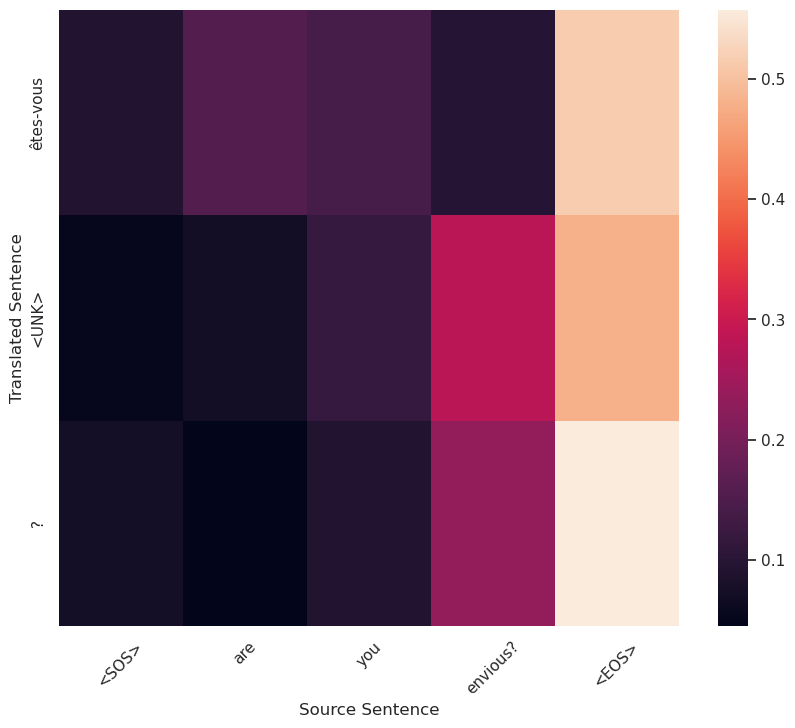

In [42]:
translated_tokens, attentions = translate_sentence(seq2seq_model, source_sentence, source_vocab, target_vocab, inv_target_vocab)  # Translate the sentence and get attention weights

print(f"Translated Sentence: {' '.join(translated_tokens)}")

visualize_attention(source_tokens, translated_tokens, attentions)  # Visualize attention

##### **Q29: How do you interpret the attention heatmap to understand which parts of the input sequence the model focused on during translation?**


In [43]:
# High attention weights (darker colors) indicate that the model focused on those input tokens when generating a particular output token.

##### **Q30: How do you extract the attention weights from the Decoder to analyze how the model's attention changes across decoding steps?**

In [44]:
example_idx = 0  # Adjust as needed
source_tokens = val_data[example_idx][0]
target_tokens = val_data[example_idx][1]

source_sentence = ' '.join(source_tokens)
target_sentence = ' '.join(target_tokens)

print(f"Source Sentence: {source_sentence}")
print(f"Target Sentence: {target_sentence}")

Source Sentence: are you envious?
Target Sentence: êtes-vous jalouse ?


Translated Sentence: êtes-vous <UNK> ?


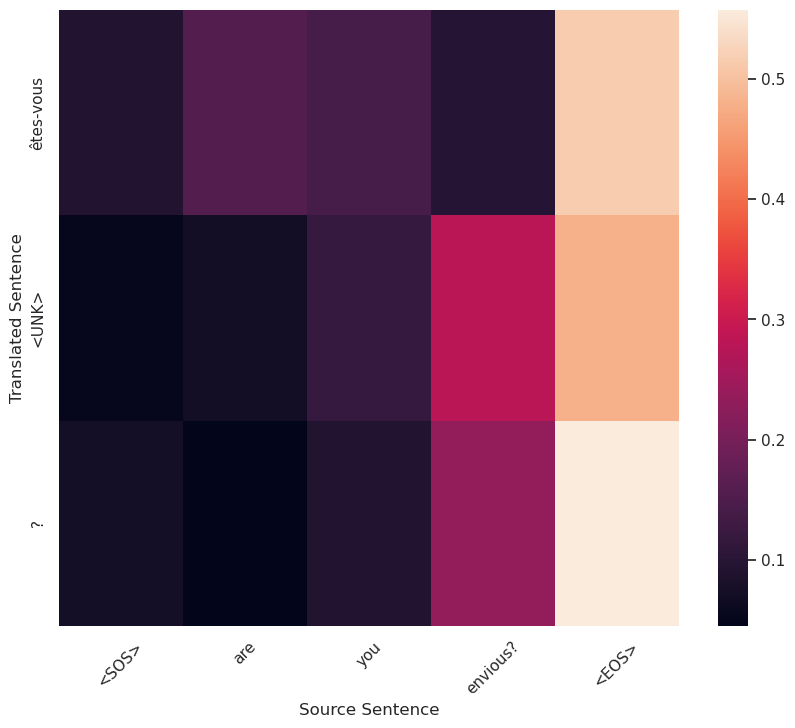

In [45]:
translated_tokens, attentions = translate_sentence(seq2seq_model, source_sentence, source_vocab, target_vocab, inv_target_vocab)

print(f"Translated Sentence: {' '.join(translated_tokens)}")

visualize_attention(source_tokens, translated_tokens, attentions)

In [46]:
source_tokens_with_special = ['<SOS>'] + source_tokens + ['<EOS>']

print(f"Length of source_tokens_with_special: {len(source_tokens_with_special)}")
print(f"Shape of attentions: {attentions.shape}")

Length of source_tokens_with_special: 5
Shape of attentions: (4, 5)


In [47]:
for t_idx, t_word in enumerate(translated_tokens):
    attn_weights = attentions[t_idx]
    max_src_idx = np.argmax(attn_weights)
    src_word = source_tokens_with_special[max_src_idx]
    print(f"At target word '{t_word}', model attended most to source word '{src_word}' with weight {attn_weights[max_src_idx]:.4f}")

At target word 'êtes-vous', model attended most to source word '<EOS>' with weight 0.5142
At target word '<UNK>', model attended most to source word '<EOS>' with weight 0.4802
At target word '?', model attended most to source word '<EOS>' with weight 0.5577


## Experimenting with hyperparameters


##### **Q31: How do you adjust the learning rate and observe its effect on the stability and performance of the attention-based seq2seq model?**


In [48]:
torch.cuda.empty_cache()

In [49]:
learning_rates = [0.01, 0.001, 0.0001]
num_epochs = 5  # Adjusted for quicker experimentation
learning_rate_losses = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    encoder = Encoder(input_dim, embed_dim, hidden_dim, num_layers).to(device)
    attention = Attention(hidden_dim).to(device)
    decoder = Decoder(output_dim, embed_dim, hidden_dim, num_layers, attention).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder, device).to(device)  # Re-instantiate models to reset parameters

    optimizer = optim.Adam(seq2seq_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=target_vocab['<PAD>'])
    train_losses = []

    for epoch in range(num_epochs):
        train_loss = train(seq2seq_model, train_loader, optimizer, criterion, clip, teacher_forcing_ratio)
        train_losses.append(train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

    learning_rate_losses[lr] = train_losses


Training with learning rate: 0.01
Epoch [1/5], Loss: 3.7736
Epoch [2/5], Loss: 3.9766
Epoch [3/5], Loss: 4.1948
Epoch [4/5], Loss: 4.4219
Epoch [5/5], Loss: 4.5236

Training with learning rate: 0.001
Epoch [1/5], Loss: 1.8562
Epoch [2/5], Loss: 1.5382
Epoch [3/5], Loss: 1.4580
Epoch [4/5], Loss: 1.4120
Epoch [5/5], Loss: 1.3888

Training with learning rate: 0.0001
Epoch [1/5], Loss: 2.3604
Epoch [2/5], Loss: 1.6681
Epoch [3/5], Loss: 1.4875
Epoch [4/5], Loss: 1.3783
Epoch [5/5], Loss: 1.2973


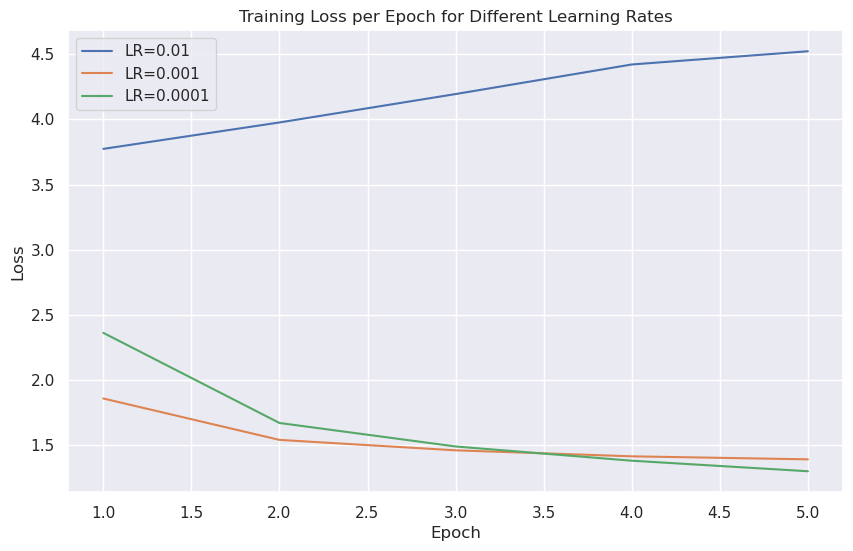

In [50]:
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(range(1, num_epochs+1), learning_rate_losses[lr], label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch for Different Learning Rates')
plt.legend()
plt.show()

##### **Q32: How do you experiment with different hidden dimensions and evaluate how they impact the performance of the model?**


In [51]:
torch.cuda.empty_cache()

In [52]:
hidden_dims = [32, 64, 128]
num_epochs = 5
hidden_dim_losses = {}

for hd in hidden_dims:
    print(f"\nTraining with hidden dimension: {hd}")
    encoder = Encoder(input_dim, embed_dim, hd, num_layers).to(device)
    attention = Attention(hd).to(device)
    decoder = Decoder(output_dim, embed_dim, hd, num_layers, attention).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder, device).to(device)

    optimizer = optim.Adam(seq2seq_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=target_vocab['<PAD>'])
    train_losses = []

    for epoch in range(num_epochs):
        train_loss = train(seq2seq_model, train_loader, optimizer, criterion, clip, teacher_forcing_ratio)
        train_losses.append(train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

    hidden_dim_losses[hd] = train_losses


Training with hidden dimension: 32
Epoch [1/5], Loss: 2.2512
Epoch [2/5], Loss: 1.8214
Epoch [3/5], Loss: 1.7372
Epoch [4/5], Loss: 1.6869
Epoch [5/5], Loss: 1.6557

Training with hidden dimension: 64
Epoch [1/5], Loss: 2.0163
Epoch [2/5], Loss: 1.6503
Epoch [3/5], Loss: 1.5695
Epoch [4/5], Loss: 1.5250
Epoch [5/5], Loss: 1.4975

Training with hidden dimension: 128
Epoch [1/5], Loss: 1.8955
Epoch [2/5], Loss: 1.5610
Epoch [3/5], Loss: 1.4814
Epoch [4/5], Loss: 1.4346
Epoch [5/5], Loss: 1.4053


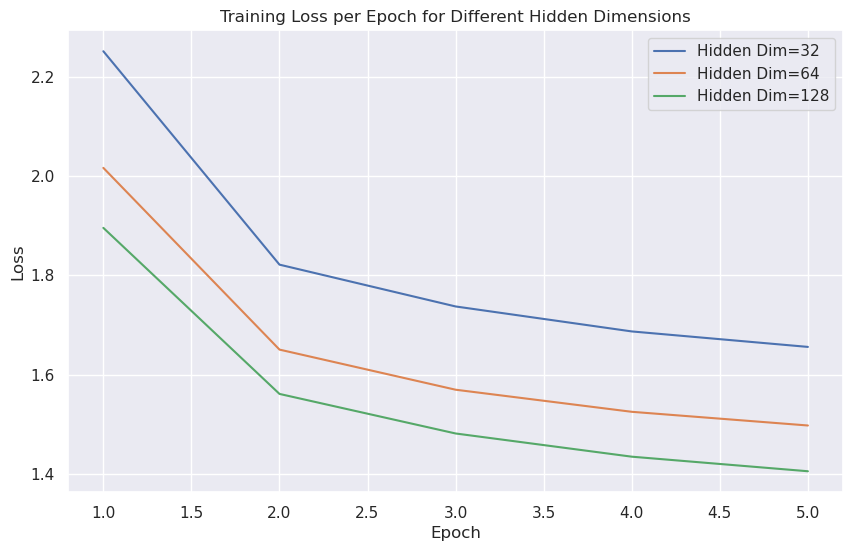

In [53]:
plt.figure(figsize=(10, 6))
for hd in hidden_dims:
    plt.plot(range(1, num_epochs+1), hidden_dim_losses[hd], label=f'Hidden Dim={hd}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch for Different Hidden Dimensions')
plt.legend()
plt.show()

##### **Q33: How do you tune the teacher forcing ratio during training and analyze how it affects the model’s convergence?**


In [54]:
torch.cuda.empty_cache()

In [55]:
teacher_forcing_ratios = [0.9, 0.3, 0.1]
num_epochs = 5
tfr_losses = {}

for ratio in teacher_forcing_ratios:
    print(f"\nTraining with teacher forcing ratio: {ratio}")
    encoder = Encoder(input_dim, embed_dim, hidden_dim, num_layers).to(device)
    attention = Attention(hidden_dim).to(device)
    decoder = Decoder(output_dim, embed_dim, hidden_dim, num_layers, attention).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder, device).to(device)

    optimizer = optim.Adam(seq2seq_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=target_vocab['<PAD>'])
    train_losses = []

    for epoch in range(num_epochs):
        train_loss = train(seq2seq_model, train_loader, optimizer, criterion, clip, ratio)
        train_losses.append(train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

    tfr_losses[ratio] = train_losses


Training with teacher forcing ratio: 0.9
Epoch [1/5], Loss: 1.5103
Epoch [2/5], Loss: 1.1935
Epoch [3/5], Loss: 1.1159
Epoch [4/5], Loss: 1.0758
Epoch [5/5], Loss: 1.0546

Training with teacher forcing ratio: 0.3
Epoch [1/5], Loss: 2.0034
Epoch [2/5], Loss: 1.6872
Epoch [3/5], Loss: 1.6041
Epoch [4/5], Loss: 1.5572
Epoch [5/5], Loss: 1.5290

Training with teacher forcing ratio: 0.1
Epoch [1/5], Loss: 2.1100
Epoch [2/5], Loss: 1.8029
Epoch [3/5], Loss: 1.7177
Epoch [4/5], Loss: 1.6716
Epoch [5/5], Loss: 1.6424


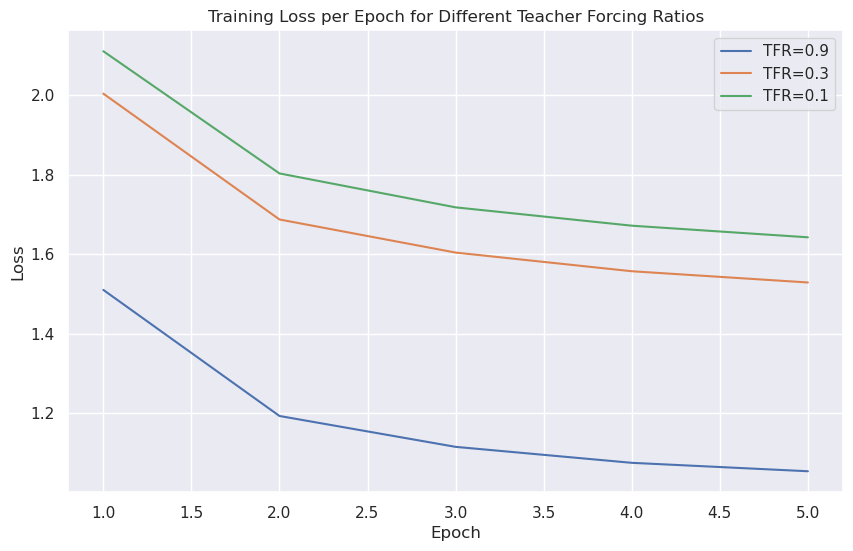

In [56]:
plt.figure(figsize=(10, 6))
for ratio in teacher_forcing_ratios:
    plt.plot(range(1, num_epochs+1), tfr_losses[ratio], label=f'TFR={ratio}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch for Different Teacher Forcing Ratios')
plt.legend()
plt.show()

##### **Q34: How do you experiment with different attention scoring functions and observe their impact on model performance?**

In [60]:
torch.cuda.empty_cache()

In [61]:
class DotProductAttention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super(DotProductAttention, self).__init__()
        self.encoder_projection = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)

    def forward(self, hidden, encoder_outputs, mask):
        # Project encoder outputs to match decoder hidden dimension:
        encoder_outputs = self.encoder_projection(encoder_outputs)  # [batch_size, seq_len, decoder_hidden_dim]
        hidden = hidden.unsqueeze(2)  # [batch_size, decoder_hidden_dim, 1]
        attention = torch.bmm(encoder_outputs, hidden).squeeze(2)  # [batch_size, seq_len]
        attention = attention.masked_fill(mask == 0, -1e10)
        return torch.softmax(attention, dim=1)

In [62]:
attention_mechanisms = {
    'AdditiveAttention': Attention(hidden_dim).to(device),
    'DotProductAttention': DotProductAttention(hidden_dim, hidden_dim).to(device)
}

num_epochs = 5
attention_losses = {}

for name, attn in attention_mechanisms.items():
    print(f"\nTraining with attention mechanism: {name}")
    encoder = Encoder(input_dim, embed_dim, hidden_dim, num_layers).to(device)
    decoder = Decoder(output_dim, embed_dim, hidden_dim, num_layers, attn).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder, device).to(device)

    optimizer = optim.Adam(seq2seq_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=target_vocab['<PAD>'])
    train_losses = []

    for epoch in range(num_epochs):
        train_loss = train(seq2seq_model, train_loader, optimizer, criterion, clip, teacher_forcing_ratio)
        train_losses.append(train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

    attention_losses[name] = train_losses


Training with attention mechanism: AdditiveAttention
Epoch [1/5], Loss: 1.8563
Epoch [2/5], Loss: 1.5400
Epoch [3/5], Loss: 1.4566
Epoch [4/5], Loss: 1.4130
Epoch [5/5], Loss: 1.3862

Training with attention mechanism: DotProductAttention
Epoch [1/5], Loss: 2.0760
Epoch [2/5], Loss: 1.7377
Epoch [3/5], Loss: 1.6540
Epoch [4/5], Loss: 1.6084
Epoch [5/5], Loss: 1.5675


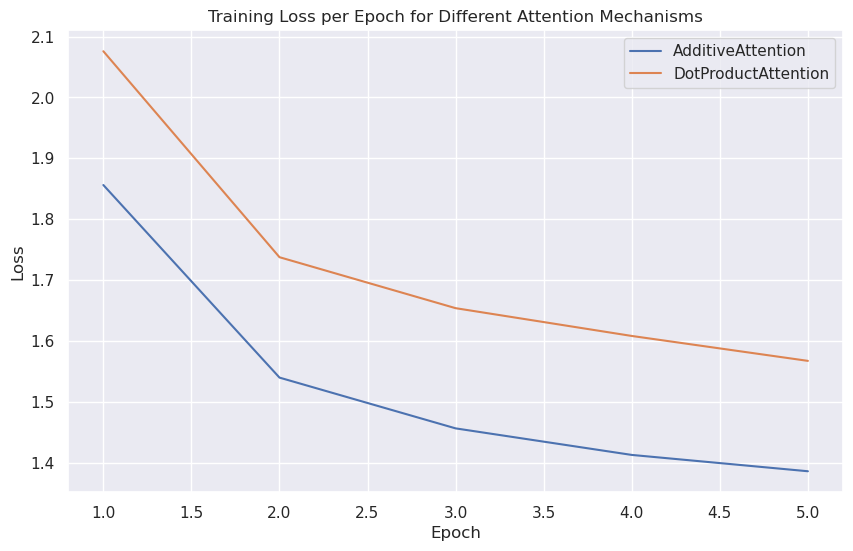

In [63]:
plt.figure(figsize=(10, 6))
for name in attention_mechanisms.keys():
    plt.plot(range(1, num_epochs+1), attention_losses[name], label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch for Different Attention Mechanisms')
plt.legend()
plt.show()

In [64]:
import shutil
import os

if os.path.exists('data'):
    shutil.rmtree('data')
    print("Folder 'data' has been deleted.")
else:
    print("Folder 'data' does not exist.")

Folder 'data' has been deleted.
